In [418]:
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from tqdm.notebook import tqdm
from xgboost import XGBRegressor, XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbalancedPipeline


In [398]:
df2 = pd.read_csv(r'DataSets\prices.csv')
info = pd.read_csv(r'DataSets\securities.csv')
df2['Daily Return'] = df2['close'] - df2['open']
df2['WentUp?'] = df2['Daily Return'] > 0

In [399]:
df2.shape

(851264, 9)

In [400]:
info.shape

(505, 8)

In [401]:
info = info[info['Ticker symbol'].isin(df2['symbol'])]
info = info[['Ticker symbol', 'GICS Sector', 'GICS Sub Industry']]

In [402]:
df2

,date,symbol,open,close,low,high,volume,Daily Return,WentUp?
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0,2.409996,True
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0,-5.259995,False
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0,-1.430000,False
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0,1.140000,True
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0,-2.040001,False
...,...,...,...,...,...,...,...,...,...
851259,2016-12-30,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0,-0.110001,False
851260,2016-12-30,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0,-0.029999,False
851261,2016-12-30,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0,-0.110000,False
851262,2016-12-30 00:00:00,AIV,44.730000,45.450001,44.410000,45.590000,1380900.0,0.720001,True


In [403]:
df2.isnull().sum()

date            0
symbol          0
open            0
close           0
low             0
high            0
volume          0
Daily Return    0
WentUp?         0
dtype: int64

In [404]:
df2['symbol'].value_counts()

symbol
AIV     1762
ZION    1762
ZBH     1762
YUM     1762
AMGN    1762
        ... 
KHC      378
HPE      304
CSRA     284
WLTW     251
FTV      126
Name: count, Length: 501, dtype: int64

In [405]:
df2 = df2.merge(info, left_on='symbol', right_on='Ticker symbol')

In [406]:
def add_moving_averages(df, column='Close', sma_window=5, ema_window=10):

    df[f'SMA_{sma_window}'] = df.groupby('symbol')[column].transform(lambda x: x.shift(1).rolling(window=sma_window).mean())
    df[f'EMA_{ema_window}'] = df.groupby('symbol')[column].transform(lambda x: x.shift(1).ewm(span=ema_window, adjust=False).mean())


    return df
def add_rsi(df, column='Close', window=14):
    delta = df[column].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

    rs = gain / loss
    df[f'RSI_{window}'] = 100 - (100 / (1 + rs))
    return df

def add_macd(df, column='Close', short_window=12, long_window=26, signal_window=9):
    df['MACD_line'] = df[column].ewm(span=short_window, adjust=False).mean() - df[column].ewm(span=long_window, adjust=False).mean()
    df['MACD_signal'] = df['MACD_line'].ewm(span=signal_window, adjust=False).mean()
    return df




In [407]:
add_moving_averages(df2, column='close', sma_window=5, ema_window=10)
#add_moving_averages(df2, column='close', sma_window=7, ema_window=3)
add_moving_averages(df2, column='close', sma_window=3, ema_window=5)
add_moving_averages(df2, column='close', sma_window=20, ema_window=50)
#add_rsi(df2, column='close', window=14)
#add_macd(df2, column='close', short_window=12, long_window=26, signal_window=9)

,date,symbol,open,close,low,high,volume,Daily Return,WentUp?,Ticker symbol,GICS Sector,GICS Sub Industry,SMA_5,EMA_10,SMA_3,EMA_5,SMA_20,EMA_50
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0,2.409996,True,WLTW,Financials,Insurance Brokers,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0,-5.259995,False,WLTW,Financials,Insurance Brokers,NaN,125.839996,NaN,125.839996,NaN,125.839996
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0,-1.430000,False,WLTW,Financials,Insurance Brokers,NaN,124.774543,NaN,123.886665,NaN,125.610192
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0,1.140000,True,WLTW,Financials,Insurance Brokers,NaN,122.988262,120.256665,120.907776,NaN,125.192145
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0,-2.040001,False,WLTW,Financials,Insurance Brokers,NaN,121.830396,117.183334,119.478518,NaN,124.855983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851259,2016-12-30,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0,-0.110001,False,ZBH,Health Care,Health Care Equipment,102.717999,102.965500,103.233332,102.985531,103.182000,107.187280
851260,2016-12-30,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0,-0.029999,False,ZION,Financials,Regional Banks,43.520001,43.131082,43.333333,43.287669,42.577500,38.929703
851261,2016-12-30,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0,-0.110000,False,ZTS,Health Care,Pharmaceuticals,53.563999,53.013153,53.593333,53.453788,51.857499,51.276696
851262,2016-12-30 00:00:00,AIV,44.730000,45.450001,44.410000,45.590000,1380900.0,0.720001,True,AIV,Real Estate,REITs,44.506001,44.136159,44.413334,44.443135,43.255500,43.176413


In [408]:
df2['Yesterday High'] = df2.groupby('symbol')['high'].shift(1)
df2['Yesterday Low'] = df2.groupby('symbol')['low'].shift(1)
df2['Yesterday return'] = df2.groupby('symbol')['Daily Return'].shift(1)

In [409]:
df2['Two Days Ago High'] = df2.groupby('symbol')['high'].shift(2)
df2['Two Days Ago Low'] = df2.groupby('symbol')['low'].shift(2)
df2['Two Days Ago return'] = df2.groupby('symbol')['Daily Return'].shift(2)

In [410]:
df2['Three Days Ago High'] = df2.groupby('symbol')['high'].shift(3)
df2['Three Days Ago Low'] = df2.groupby('symbol')['low'].shift(3)
#df2['Three Days Ago return'] = df2.groupby('symbol')['Daily Return'].shift(3)

In [411]:
df2['Four Days Ago High'] = df2.groupby('symbol')['high'].shift(4)
df2['Four Days Ago Low'] = df2.groupby('symbol')['low'].shift(4)
#df2['Four Days Ago return'] = df2.groupby('symbol')['Daily Return'].shift(4)

In [412]:
df2.isnull().sum()
df2.dropna(inplace=True)
df2.shape

(841244, 28)

In [413]:
df2

,date,symbol,open,close,low,high,volume,Daily Return,WentUp?,Ticker symbol,...,Yesterday High,Yesterday Low,Yesterday return,Two Days Ago High,Two Days Ago Low,Two Days Ago return,Three Days Ago High,Three Days Ago Low,Four Days Ago High,Four Days Ago Low
20,2016-02-03 00:00:00,WLTW,113.379997,114.050003,109.639999,114.639999,896300.0,0.670006,True,WLTW,...,113.860001,109.750000,-2.690002,114.849998,112.900002,0.500000,114.589996,111.669998,112.970001,109.900002
21,2016-02-04 00:00:00,WLTW,114.080002,115.709999,114.080002,116.320000,956300.0,1.629997,True,WLTW,...,114.639999,109.639999,0.670006,113.860001,109.750000,-2.690002,114.849998,112.900002,114.589996,111.669998
22,2016-02-05 00:00:00,WLTW,115.120003,114.019997,109.709999,116.489998,997100.0,-1.100006,False,WLTW,...,116.320000,114.080002,1.629997,114.639999,109.639999,0.670006,113.860001,109.750000,114.849998,112.900002
23,2016-02-08 00:00:00,WLTW,113.300003,111.160004,110.459999,113.300003,1200500.0,-2.139999,False,WLTW,...,116.489998,109.709999,-1.100006,116.320000,114.080002,1.629997,114.639999,109.639999,113.860001,109.750000
24,2016-02-09 00:00:00,WLTW,111.169998,110.650002,109.639999,112.110001,1725200.0,-0.519996,False,WLTW,...,113.300003,110.459999,-2.139999,116.489998,109.709999,-1.100006,116.320000,114.080002,114.639999,109.639999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851259,2016-12-30,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0,-0.110001,False,ZBH,...,103.739998,102.830002,0.500000,104.199997,102.839996,0.220002,103.389999,101.980003,102.699997,101.430000
851260,2016-12-30,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0,-0.029999,False,ZION,...,43.639999,42.630001,-0.479999,44.029999,43.180000,-0.750000,44.150002,43.669998,43.939999,43.590000
851261,2016-12-30,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0,-0.110000,False,ZTS,...,53.779999,53.400002,0.149998,53.849998,53.349998,-0.319999,54.150002,53.650002,53.779999,53.180000
851262,2016-12-30 00:00:00,AIV,44.730000,45.450001,44.410000,45.590000,1380900.0,0.720001,True,AIV,...,44.840000,44.250000,0.340000,44.450001,44.000000,-0.130001,44.939999,44.240002,44.910000,44.480000


In [415]:
X = df2.drop(['date', 'symbol', 'close', 'Daily Return', 'high', 'low', 'WentUp?'], axis=1)
y = df2['WentUp?']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [382]:
#,'MACD_line', 'MACD_signal' 'RSI_14',  'volume','Three Days Ago return', 'Four Days Ago return', 'EMA_3', 'SMA_7',
prep = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['open', 'EMA_50', 'SMA_20',  'SMA_5',  'EMA_10', 'SMA_3', 'EMA_5', 
                                   'Yesterday High', 'Yesterday Low', 'Yesterday return', 'Two Days Ago High', 'Two Days Ago Low', 'Two Days Ago return',
                                   'Three Days Ago High', 'Three Days Ago Low', 
                                   'Four Days Ago High', 'Four Days Ago Low']),
        ('cat', TargetEncoder(), ['GICS Sector', 'GICS Sub Industry'])
    ])

In [327]:
pipe = Pipeline(
    steps=[
        ('preprocessor', prep),
        ('model', XGBClassifier(verbose = 2, n_jobs = -1, random_state=42))
    ])

In [177]:
# param_grid = {
#     'model__n_estimators': [100, 200],
#     'model__max_depth': [3, 5, 7],
#     'model__learning_rate': [0.01, 0.1, 0.2],
#     'model__subsample': [0.8, 1.0],
#     'model__colsample_bytree': [0.8, 1.0]
# }

In [178]:
# grid_search = GridSearchCV(estimator=pipe,
#                            param_grid=param_grid,
#                            cv=5,
#                            scoring='accuracy',
#                            verbose=2,
#                            n_jobs=-1)

In [383]:
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    accuracy_score_value = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    print(f"--- {name} ---")
    print(f"Accuracy Score: {accuracy_score_value:.3f}")
    print(f"Classification: \n {class_report}")
    print("Confusion Matrix:")
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap = 'Blues', xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
    plt.title(f'Confusion Matrix for The model')
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.show()
    print()


9 Minute Fit

In [95]:
# grid_search.fit(X_train, y_train)


In [96]:
# best_params = grid_search.best_params_
# print(f"Best Parameters: {best_params}")

In [97]:
# best_model = grid_search.best_estimator_
# best_model.fit(X_train, y_train)

Best Parameters: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.2, 'model__max_depth': 7, 'model__n_estimators': 200, 'model__subsample': 1.0}

In [388]:
best = Pipeline(steps=[
    ('preprocessor', prep),
    ('model', XGBClassifier(colsample_bytree =1, learning_rate = 0.2, max_depth = 7,
                            n_estimators = 200, subsample = 1
                            , verbosity = 1, n_jobs = -1, random_state=42))
])

In [389]:
best.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['open', 'EMA_50', 'SMA_20',
                                                   'SMA_5', 'EMA_10', 'SMA_3',
                                                   'EMA_5', 'Yesterday High',
                                                   'Yesterday Low',
                                                   'Yesterday return',
                                                   'Two Days Ago High',
                                                   'Two Days Ago Low',
                                                   'Two Days Ago return',
                                                   'Three Days Ago High',
                                                   'Three Days Ago Low',
                                                   'Four Days Ago High',
                                                   'Four Days Ago Low']),
                                                 ('cat', TargetEncoder(),
                                                  ['GIC...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=-1,
                               num_parallel_tree=None, ...))])

Logistic Regression Baseline: 0.59

--- XG Classifier with all factors ---
Accuracy Score: 0.512
Classification: 
               precision    recall  f1-score   support

       False       0.50      0.31      0.38     81581
        True       0.52      0.70      0.60     86668

    accuracy                           0.51    168249
   macro avg       0.51      0.51      0.49    168249
weighted avg       0.51      0.51      0.49    168249

Confusion Matrix:


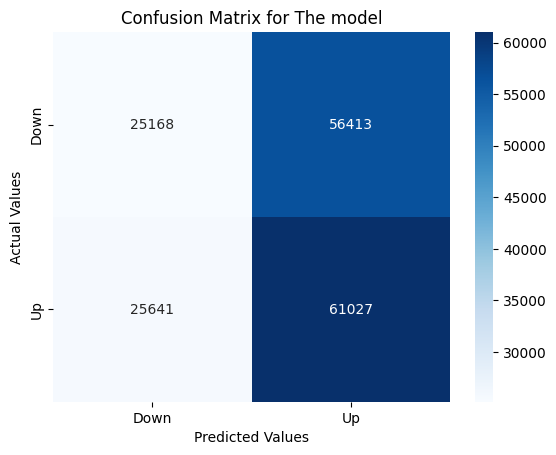

In [390]:
evaluate_model(best, X_test, y_test, "XG Classifier with all factors")


New best: 0.596
New best: 0.597

In [101]:
preprocessor = pipe.named_steps['preprocessor']
if isinstance(preprocessor, ColumnTransformer):
    transformed_feature_names = preprocessor.get_feature_names_out()
else:
    transformed_feature_names = X_train.columns

#Getting feature importance from model
my_model = best.named_steps['model']
feature_importance = my_model.feature_importances_

#Putting the two into a data frame for easy access
importance_df = pd.DataFrame({'Feature': transformed_feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

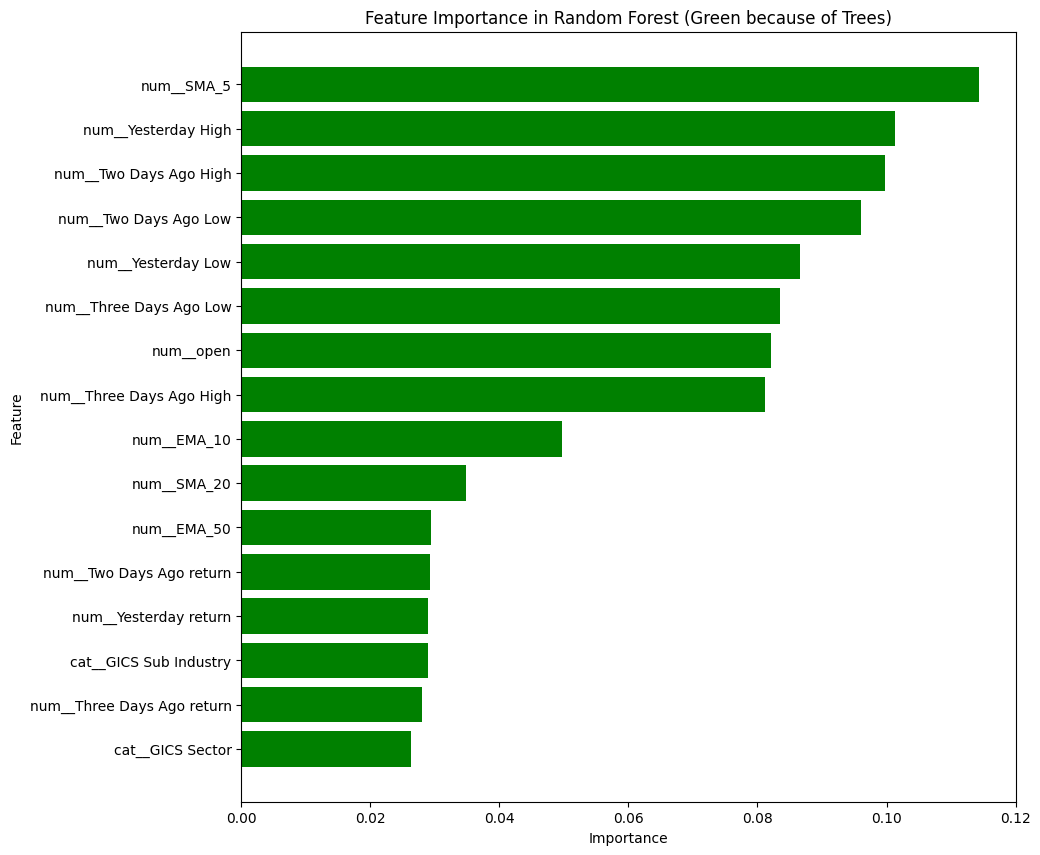

In [102]:
plt.figure(figsize=(10, 10))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='green')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Random Forest (Green because of Trees)")
plt.gca().invert_yaxis()
plt.show()

In [103]:
# start_time = time.time()
# with tqdm(total=rfr.n_estimators, desc="Fitting model") as pbar:
#     for i in range(rfr.n_estimators):
#         rfr.set_params(n_estimators=i+1)  # Incrementally fitting
#         rfr.fit(X_train, y_train)
#         elapsed_time = time.time() - start_time
#         estimated_total_time = (elapsed_time / (i+1)) * rfr.n_estimators
#         remaining_time = estimated_total_time - elapsed_time
#         pbar.set_postfix({"ETA": f"{remaining_time:.2f} sec"})
#         pbar.update(1)

In [104]:
# param_grid = {
#     'model__penalty': ['l2', None],
#     'model__C': [10],
# }

In [419]:
logpipe = imbalancedPipeline(
    steps=[
        ('preprocessor', prep),
        ('smote', SMOTE(random_state=42)),
        ('model', LogisticRegression(penalty= 'l2',C = 10, random_state=42, max_iter=1000,class_weight='balanced', verbose = 2, n_jobs = -1))
    ])

In [420]:
# grid = GridSearchCV(estimator=logpipe,
#                     param_grid=param_grid,
#                     scoring='accuracy',
#                     cv=5,
#                     verbose=2,
#                     n_jobs=-1)

In [421]:
logpipe.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['open', 'EMA_50', 'SMA_20',
                                                   'SMA_5', 'EMA_10', 'SMA_3',
                                                   'EMA_5', 'Yesterday High',
                                                   'Yesterday Low',
                                                   'Yesterday return',
                                                   'Two Days Ago High',
                                                   'Two Days Ago Low',
                                                   'Two Days Ago return',
                                                   'Three Days Ago High',
                                                   'Three Days Ago Low',
                                                   'Four Days Ago High',
                                                   'Four Days Ago Low']),
                                                 ('cat', TargetEncoder(),
                                                  ['GICS Sector',
                                                   'GICS Sub Industry'])])),
                ('smote', SMOTE(random_state=42)),
                ('model',
                 LogisticRegression(C=10, class_weight='balanced',
                                    max_iter=1000, n_jobs=-1, random_state=42,
                                    verbose=2))])

--- Logistic Regression with all factors ---
Accuracy Score: 0.504
Classification: 
               precision    recall  f1-score   support

       False       0.49      0.38      0.42     81581
        True       0.52      0.62      0.56     86668

    accuracy                           0.50    168249
   macro avg       0.50      0.50      0.49    168249
weighted avg       0.50      0.50      0.50    168249

Confusion Matrix:


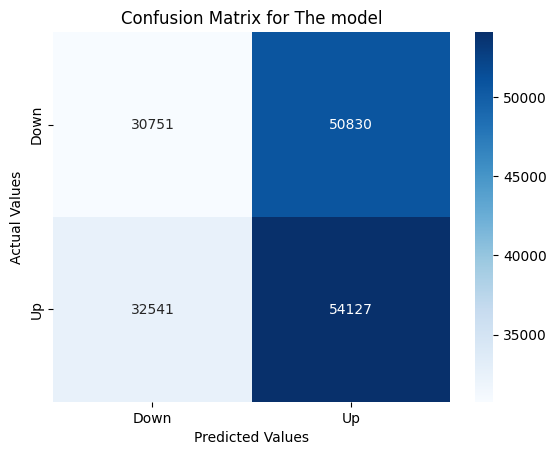

In [422]:
evaluate_model(logpipe, X_test, y_test, "Logistic Regression with all factors")

Best score: 0.663 \
Best Score: 0.779 \
Best Score: 0.84 \
Best Score: 0.894 \
Best Score: 0.925

In [356]:
model = logpipe.named_steps['model']
feature_names = logpipe.named_steps['preprocessor'].get_feature_names_out()
importance = np.abs(model.coef_[0])
feature_importance = pd.Series(importance, index=feature_names).sort_values(ascending=False)

In [357]:
print(feature_importance)

num__EMA_50                   0.132999
cat__GICS Sub Industry        0.075583
num__Three Days Ago Low       0.055424
num__Two Days Ago Low         0.049587
num__Four Days Ago Low        0.046613
num__Yesterday Low            0.042743
cat__GICS Sector              0.036234
num__Three Days Ago High      0.027363
num__SMA_3                    0.016463
num__SMA_20                   0.012812
num__Yesterday return         0.011141
num__SMA_5                    0.010040
num__Yesterday High           0.009756
num__Four Days Ago High       0.009521
num__open                     0.009144
num__SMA_7                    0.005701
num__Two Days Ago High        0.005471
num__Four Days Ago return     0.005070
num__EMA_5                    0.002580
num__Two Days Ago return      0.002329
num__EMA_10                   0.001515
num__Three Days Ago return    0.001319
num__EMA_3                    0.000629
dtype: float64
